In [2]:
import numpy
import cv2
from keras import *
from sklearn.model_selection import train_test_split
from os import listdir
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

import zipfile as zf
files = zf.ZipFile("archive28.zip", 'r')
files.extractall('Alzheimer28_data')
files.close()

# Data part

In [3]:
directory_root = "/Users/PC/ML Project/Alzheimer28_data"
default_image_size = tuple((128, 128))

In [90]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [91]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Mild_Demented ...
[INFO] Processing Moderate_Demented ...
[INFO] Processing Non_Demented ...
[INFO] Processing Very_Mild_Demented ...
[INFO] Image loading completed


# CNN Model - low accuracy 

In [10]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

In [5]:
#Part 1 - Build Model
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import LeakyReLU

In [94]:
#temp
labels = numpy.full((200,1),1)
label = numpy.full((200,1),2)
lab = numpy.concatenate((labels,label),axis=0)

In [6]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='LeakyReLU', input_shape=(128,128,3)))
model.add(Conv2D(64, (3, 3), activation='LeakyReLU'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Conv2D(64, (3, 3), padding='same', activation='LeakyReLU'))
model.add(Conv2D(64, (3, 3), activation='LeakyReLU'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Conv2D(128, (3, 3), padding='same', activation='LeakyReLU'))
model.add(Conv2D(128, (3, 3), activation='LeakyReLU'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Conv2D(128, (3, 3), padding='same', activation='LeakyReLU'))
model.add(Conv2D(128, (3, 3), activation='LeakyReLU'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(1024, activation='LeakyReLU'))
model.add(Dropout(0.6))
#model.add(Dense(39, activation='softmax'))
model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

In [96]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [97]:
np_image_list = numpy.array(image_list, dtype=numpy.float16) / 225.0

In [98]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

In [99]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [100]:
aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [32]:
model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

In [101]:
model.fit(
    aug.flow(x_train, y_train, batch_size=8),
    validation_data=(x_test, y_test),
    steps_per_epoch=67,
    epochs=10)

Epoch 1/10
67/67 [==============================] - 50s 690ms/step - loss: 1.3452 - accuracy: 0.3352 - val_loss: 1.3348 - val_accuracy: 0.2782
Epoch 2/10
67/67 [==============================] - 39s 575ms/step - loss: 1.3513 - accuracy: 0.2976 - val_loss: 5.4507 - val_accuracy: 0.0827
Epoch 3/10
67/67 [==============================] - 40s 595ms/step - loss: 1.4563 - accuracy: 0.2900 - val_loss: 518.8051 - val_accuracy: 0.0827
Epoch 4/10
67/67 [==============================] - 40s 600ms/step - loss: 2.2255 - accuracy: 0.2825 - val_loss: 137.8089 - val_accuracy: 0.3684
Epoch 5/10
67/67 [==============================] - 39s 580ms/step - loss: 1.3604 - accuracy: 0.2806 - val_loss: 76.3488 - val_accuracy: 0.2782
Epoch 6/10
67/67 [==============================] - 39s 582ms/step - loss: 1.3420 - accuracy: 0.2712 - val_loss: 22.6979 - val_accuracy: 0.3684
Epoch 7/10
67/67 [==============================] - 39s 581ms/step - loss: 1.3333 - accuracy: 0.2938 - val_loss: 22.8197 - val_accuracy:

# CNN Model - high accuracy

## changing split way and model.compile loss function to get high accuracy 

In [102]:
import splitfolders
#splitfolders.ratio('/Users/PC/ML Project/Alzheimer28_data/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

In [7]:
#trying another split way
IMG_HEIGHT = 128
IMG_WIDTH = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [8]:
# to see the names of the classes
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

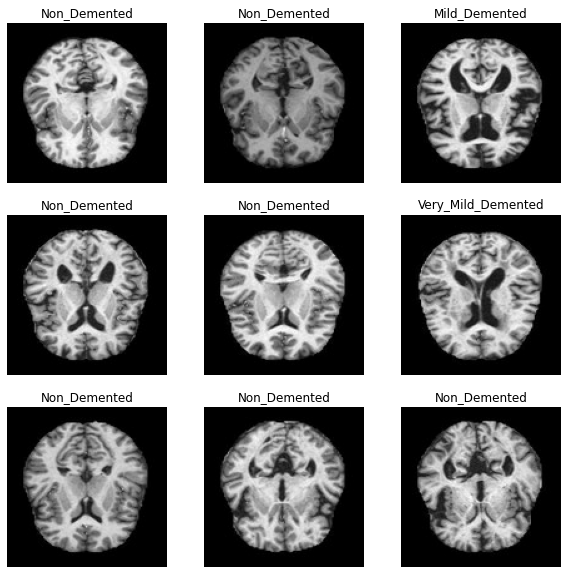

In [11]:
# to display 9 images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<function matplotlib.pyplot.show(close=None, block=None)>

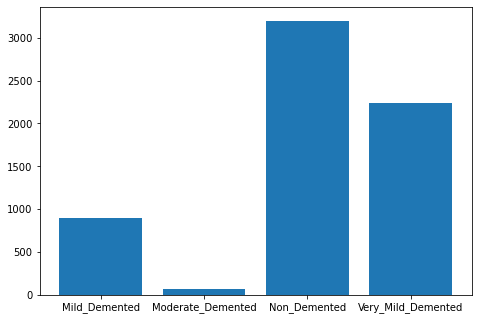

In [13]:
# to count the images in each class, then display it as histogram
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

In [14]:
#Compiling the CNN (new loss function)
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "adam",metrics=["accuracy"])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [16]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1)

Epoch 1/10
80/80 [==============================] - 339s 4s/step - loss: 11.1673 - accuracy: 0.4306 - val_loss: 1.3263 - val_accuracy: 0.5008
Epoch 2/10
80/80 [==============================] - 310s 4s/step - loss: 1.0113 - accuracy: 0.5124 - val_loss: 1.0505 - val_accuracy: 0.5008
Epoch 3/10
80/80 [==============================] - 342s 4s/step - loss: 0.9930 - accuracy: 0.5241 - val_loss: 0.9632 - val_accuracy: 0.5524
Epoch 4/10
80/80 [==============================] - 348s 4s/step - loss: 0.9711 - accuracy: 0.5290 - val_loss: 0.9538 - val_accuracy: 0.5853
Epoch 5/10
80/80 [==============================] - 322s 4s/step - loss: 0.9515 - accuracy: 0.5499 - val_loss: 1.0800 - val_accuracy: 0.5571
Epoch 6/10
80/80 [==============================] - 322s 4s/step - loss: 0.9426 - accuracy: 0.5585 - val_loss: 1.0984 - val_accuracy: 0.5477
Epoch 7/10
46/80 [================>.............] - ETA: 2:12 - loss: 0.9019 - accuracy: 0.5795

KeyboardInterrupt: 